<a href="https://colab.research.google.com/github/CastleJH/CastleMouse/blob/master/lesson6/lesson6_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


rossmann_data_clean.ipynb를 통해 만든 train_clean과 test_clean은 다시 만드는 일이 없도록 내 구글드라이브에 저장시켜놨다. 그렇기 때문에 구글드라이브에 연결한다.

In [4]:
path = Config.data_path()/'rossmann'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/rossmann')

In [0]:
! cp '/content/gdrive/My Drive/fastai-v3/train_clean' '/root/.fastai/data/rossmann'
! cp '/content/gdrive/My Drive/fastai-v3/test_clean' '/root/.fastai/data/rossmann'

구글드라이브의 train_clean과 test_clean을 대상 디렉토리로 복사한다.

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
train_df = pd.read_pickle(path/'train_clean')

train_clean을 읽어오고,

In [7]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


앞의 5열을 보여준다. 중간이 생략되긴 했지만, 보여진 부분의 데이터가 강의자의 데이터와 일치하는 것으로 보아 rossmann_data_clean.ipynb에서 train과 test pickle이 잘 만들어진 것 같다.

In [8]:
n = len(train_df); n

844338

데이터 수는 이정도이다.

### Experimenting with a sample

지금 배울것은 preprocesses인데, 익히 써온 transforms와 비슷하다(이것은 이번 강의에서 후에 다룰 data augmentation의 방법이기도 하다). 그러나 다른점이 있다면, transforms는 샘플링 될 때마다 다른 값들로 바뀌지만, preprocesses는 그 어느 train을 시작하기 전이든지 딱 한번만 적용되고, 이를 통해 적용된 상태나 값이 validation이랑 test set에도 공유된다.

사실 preprocesses는 모르는 사이에 이미 해봤던 것이다. 이전 lesson에서 펫을 구분할 때 얘들을 모두 숫자로 바꿔서 train했었는데, 바로 이게 preprocessor가 해준 것이다.

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

본격적으로 전체 데이터를 다루기 전에 전체 데이터에서 샘플로 2000개 데이터를 랜덤하게 뽑아서 실험해볼 것이다. 적절히 섞어서 절반씩 train과 test데이터로 설정했다. 다시 각 데이터에서 연속적인 데이터는 competitionDistance와 Mean_Humidity를 가져오고, 카테고리 데이터는 stor, DayOfWeek, PromoInterval을 가져온 후, Sales를 마지막에 추가해주면서 샘플 데이터 프레임을 마련했다.

In [10]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
891,894,5,NaN,190.0,61,11866
1364,252,4,"Feb,May,Aug,Nov",22330.0,73,12166
1367,255,4,"Feb,May,Aug,Nov",4630.0,73,7510
2111,1001,4,"Jan,Apr,Jul,Oct",19640.0,58,6418
2830,606,3,NaN,2260.0,54,6338


내가 랜덤하게 가져오게 된 train 데이터들은 다음과 같다. 앞의 5개를 보니 위에서 고른 6개 기준으로 잘 이루어져있다. 참고로 PromoInterval에서 NaN인 경우는 값이 없다는 뜻이다.

In [11]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
425064,903,5,NaN,7290.0,67,10398
425097,936,5,NaN,580.0,53,5581
425639,364,4,"Mar,Jun,Sept,Dec",13620.0,46,3920
426407,21,3,"Jan,Apr,Jul,Oct",550.0,68,3019
426987,604,3,NaN,10950.0,78,5795


test 데이터들도 train처럼 정상적으로 만들어졌다. 

In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

이제 preprocessing 작업이다. 지금 볼 preprocessor는 Categorify이다. Categorify가 해주는 것은 Image Classification에서의 .classes와 비슷하다. 존재하는 것이 가능한 값들을 모두 찾아서 리스트를 만든 만든다음에 숫자로 바꿔준다. 테스트 데이터 프레임에는 이전에 만든 카테고리와 같은 카테고리를 만들겠다고 해준다(test=True).

In [13]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
425064,903,5,NaN,7290.0,67,10398
425097,NaN,5,NaN,580.0,53,5581
425639,364,4,"Mar,Jun,Sept,Dec",13620.0,46,3920
426407,21,3,"Jan,Apr,Jul,Oct",550.0,68,3019
426987,NaN,3,NaN,10950.0,78,5795


그 후 다시 데이터를 확인해보면, 겉으로 보기에는 이전이랑 똑같이 그저 문자열로 보인다. 하지만 사실 이것은 내부적으로는 숫자를 저장하고 있는 상태이다.

In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

이렇게 PromoInterval에 어떤 카테고리들이 존재하는지 볼 수 있다(fastai에서는 classes라고 했는데, Pandas에서는 categories라고 하니 명칭은 별 상관 없다).

In [15]:
small_train_df['PromoInterval'].cat.codes[:5]

891    -1
1364    0
1367    0
2111    1
2830   -1
dtype: int8

실제로 cat.codes로 promoInterval의 카테고리값을 읽어보면 다음과 같이 숫자로 구성되어 있는 것을 알 수 있다. 위의 샘플 train set과 비교해보면, 'Jan,Ar,Jul,Oct'가 1(바로 위 코드로 나타나는 리스트에서도 보면 인덱스가 1이다)이고, NaN은 -1로 여겨지는 것을 알 수 있다. 

embedding matrix에서는 -1을 찾으면 안되니 NaN을 의미하는 것이 -1이라면 문제가 된다. fastai에서는 이 경우 모두 1을 더해주며 문제를 해결했었다.

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

여기서 새로운 preprocessor를 써볼 것인데 바로 FillMissing이다. 아까와 마찬가지로 데이터 프레임들을 넣어주고, test는 이전 결과와 동일하게 적용시켜준다.

In [17]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
36414,622,3,NaN,2180.0,74,4030,True
102713,291,6,NaN,2180.0,55,3658,True
246606,622,1,NaN,2180.0,75,3943,True


이렇게하면 columnname_na라는 열이 생성되는데 missing이 일어날 때마다 True로 세팅된다. 그 후 columnname(여기서는 CompetitionDistance이다)을 중앙값으로 바꿔준다.

이 작업들이 일어나는 이유는, 일단 값이 없다는 것 자체도 중요한 요소이므로 이것을 boolean값을 가지는 열을 만들어서 저장하게된다. 그래서 모델이 이 값도 예측에 쓰도록 해준다. 그런데 우리는 CompetitonDistance가 연속적인 값을 가지게 해줘야한다. 그래서 중앙값을 갖게 해준다.

### Preparing full data set

이런저런 과정들이 필요하다고는 하지만 위처럼 일일히 해줄 필요는 없다. 다음 코드들은 한번에 하는 모습을 보여준다.

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

우선 다시 데이터프레임으로 읽고,

In [19]:
len(train_df),len(test_df)

(844338, 41088)

데이터 개수는 이정도이다.

In [0]:
procs=[FillMissing, Categorify, Normalize]

이런 전처리 과정들이 필요하다고 해준 뒤,

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

카테고리와 연속값들을 알려주고,

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [23]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [24]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [26]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

익숙한 data block API를 써서 한번에 전처리 과정들을 적용시켜주며 데이터셋을 만들게된다.

주의해야 할 부분이 label_cls=FloatList이다(물론, 이게 의미하는건 우리의 목표인 sales이다). 만약 label의 값의 데이터 형이 float였다면 fastai는 내가 regression을 하리라고 인식하지만, 현재 이 값의 데이터형은 int이고 이 경우 fastai는 내가 classification을 하리라고 인식하게 된다. 그래서 우리는 라벨링 할 때, 우리가 주는 것이 카테고리 리스트가 아니라 float리스트임을 알려주고 이를 통해 fastai가 regression을 하도록 만든다.

그리고 log를 취해줌으로써 비중을 낮춰주는데, 이것으로 인해 뒤의 작업이 필요하다.

In [28]:
doc(FloatList)

독스도 종종 쓰도록!

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

앞에서 로그를 취했으니, y_range도 당연히 동일하게 최대값을 가져와 로그를 취해준다(다만 실제 최대값보다는 살짝 큰 값에다 취해준다. 왜냐하면 데이터 범위가 실제 최대범위보다는 살짝 큰것이 좋으니까). 이렇게 해서 나온 값이 우리의 최대값이 된다. 이제 우리의 y_range는 0부터 실제 max보다 살짝 큰 값에 로그를 취한 것이 된다.

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

learner를 만들어준다.
여기서 dropout이라는 개념을 배우게된다! 간단히 말하면, dropuout은 regularization의 일종이다.

우선 layers를 보면 [1000, 500]이다. 즉, activation input은 1000, activation output은 500이므로 weigth matrix에 원소가 500000개나 있을것이라는 의미이니 엄청난 양이다. 다시말해, overfitting이 일어날것이다. 이를 방지하기 위해서 ps=[0.001, 0.01], emb_drop=0.04를 인자로 줌으로써 dropout을 한다.
dropout을 하면, train할 때 신경망의 hidden layer에서 랜덤하게 일정확률로 노드가 죽는다. 이렇게 하면 연관된 weight값들이 사라지므로 overfitting을 방지할 수 있다.
그 후 모델을 테스트할 때는 dropout을 꺼서 모든 노드를 활성화한다. 대신 가중치에 dropout이 적용된 확률 p가 곱해지게 된다.

In [31]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

모델의 형태를 보여주면 다음과 같이 생겼다. 주목할 부분은 BatchNorm인데, Batch norm은 learning rate를 키울수 있게 해준다. 이것은 모델에서 직접적으로 scale을 조정하고 평균을 바꾸는 것이라고 생각하면 된다.


In [32]:
len(data.train_ds.cont_names)

16

In [33]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


그다음부턴 똑같으므로 생략한다. train하고 loss 수준 보여준다.

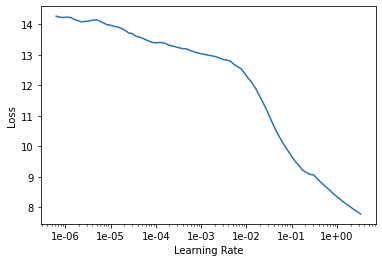

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.023156,0.020889,0.147670,04:00
1,0.019411,0.016589,0.127511,04:01
2,0.015294,0.016139,0.126245,04:02
3,0.012857,0.013219,0.116289,04:02
4,0.010683,0.011761,0.104094,04:01


In [0]:
learn.save('1')

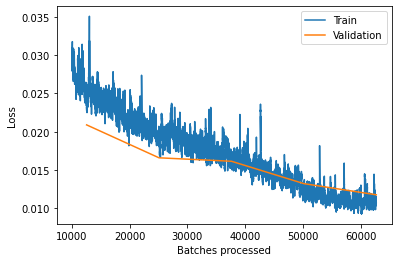

In [37]:
learn.recorder.plot_losses(skip_start=10000)

그래프를 보니 너무 적지도 않고 많지도 않고 적당히 train된 것 같다. 

In [0]:
learn.load('1');

In [39]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012241,0.017887,0.120846,04:00
1,0.011543,0.013783,0.114503,04:01
2,0.010299,0.019883,0.126027,04:01
3,0.010015,0.018132,0.123765,04:01
4,0.009134,0.014540,0.118886,04:03


In [40]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011053,0.018618,0.127076,04:03
1,0.011302,0.016839,0.118665,04:02
2,0.010681,0.015452,0.114124,04:02
3,0.009599,0.015616,0.115409,04:05
4,0.009670,0.018205,0.117886,04:05


(10th place in the competition was 0.108)

In [41]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)